 *To run in Colab*: https://colab.research.google.com/drive/1398YuV_7r9c9223c9PFWV6RBOyWPKlaq?usp=sharing

In [ ]:
using Pkg
Pkg.add("Graphs")
Pkg.add("GraphIO")
Pkg.add("Plots")


   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`
   Resolving package versions...
    Updating `~/.julia/environments/v1.8/Project.toml`
⌅ [91a5bcdd] + Plots v1.39.0
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


In [4]:
using GraphIO.NET
using Graphs

file_path = "A1-Networks/real/dolphins.net"
network=Graphs.loadgraph(file_path, "graph_key", NETFormat())

# Reading the .net file
#graph = GraphIO.loadgraph(file_path, GraphIO.PajekFormat())

{62, 159} undirected simple Int64 graph

In [7]:
using Plots

# Function to calculate the degree probability distribution function and the complimentary cummulative distribution function

function degree_pdf(graph, num_bins::Int=10, log_scale::Bool=false, CCDF::Bool=false)

    degree_counts = Graphs.degree_histogram(graph)

    # Calculate probabilities
    num_nodes = nv(graph)
    pdf =sort( Dict(degree => count / num_nodes for (degree, count) in degree_counts))

    degrees = collect(keys(pdf))
    probabilities = collect(values(pdf))

    function custom_xformatter(x)
      return string(round(x, digits=3))  # Round to 1 decimal place
    end

    if log_scale

    # Find 𝑘min = min(𝑘) and 𝑘max = max(𝑘)
    k_min = minimum(degree(graph))
    k_max = maximum(degree(graph))


    log_data = log.(degree(network))
    bin_edges = range(log(k_min), stop=log(k_max + 1), length=num_bins+1)
    total_elements = length(log_data)

    bin_counts = zeros(Int, length(bin_edges))

    for element in log_data
        # Find the index of the bin the element belongs to
        bin_index = findfirst(x -> x >= element, bin_edges[2:length(bin_counts)])
        # Increment the count for the corresponding bin
        bin_counts[bin_index] += 1
      end

    bin_counts=bin_counts[1:length(bin_counts)-1]

    probabilities=bin_counts/total_elements

        # Calculate CCDF
        if CCDF
          ccdf_values = 1.0 .- cumsum(probabilities)

          println(ccdf_values)


          plot=bar(bin_edges, ccdf_values,  xlabel="log(k)", ylabel="Comp. Cumm. Log(Pk)", title="CCDF Log-Log Histogram",xticks=bin_edges, legend=false,bar_edges=false,xrotation=45, xformatter=custom_xformatter )

        else
          plot=bar(bin_edges, probabilities,  xlabel="log(k)", ylabel="Log(Pk)", title="Log-Log PDF Histogram",xticks=bin_edges, legend=false,bar_edges=false,xrotation=45, xformatter=custom_xformatter )

        end

    else

      if CCDF
        ccdf_values = 1.0 .- cumsum(probabilities)
        println(probabilities, length(probabilities))
        println(ccdf_values)
        plot=histogram(degrees, weights=probabilities, xlabel="Degree (K)", ylabel="Comp. Cum. Prob. (P(K))",title="CCDF Histogram", legend=false, bins=num_bins, xformatter=custom_xformatter )

        bin_edges=collect(plot[1][1][:x])
        probabilities=collect(plot[1][1][:y])
        ccdf_values = 1.0 .- cumsum(probabilities)

        plot=bar(bin_edges, probabilities,  xlabel="log(k)", ylabel="Log(Pk)", title="Log-Log PDF Histogram",xticks=bin_edges, legend=false,bar_edges=false,xrotation=45, xformatter=custom_xformatter )


      else
        plot = histogram(degrees, weights=probabilities, xlabel="Degree (K)", ylabel="Probability (P(K))", title="PDF Histogram" ,legend=false, bins=num_bins, xformatter=custom_xformatter )
      end

    end

    return plot
end


degree_pdf (generic function with 4 methods)

[0.14516129032258066, 0.0967741935483871, 0.0967741935483871, 0.08064516129032258, 0.12903225806451613, 0.12903225806451613, 0.11290322580645161, 0.06451612903225806, 0.06451612903225806, 0.03225806451612903, 0.03225806451612903, 0.016129032258064516]12
[0.8548387096774194, 0.7580645161290323, 0.6612903225806451, 0.5806451612903226, 0.4516129032258065, 0.32258064516129037, 0.20967741935483875, 0.14516129032258063, 0.08064516129032262, 0.048387096774193616, 0.016129032258064613, 1.1102230246251565e-16]


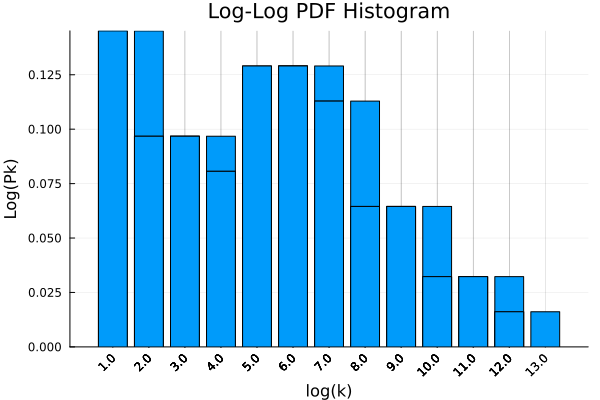

In [11]:
#degree_pdf(graph, bins, log_scale, CCDF)
degree_pdf(network,10,false,true)

In [14]:

using Plots

 #Fucntion to select the number of decimals displayed in the charts
  function custom_xformatter(x)
    return string(round(x, digits=3))
  end

# Function to calculate the degree probability distribution function and the complimentary cummulative distribution function

function degree_pdf2(graph, num_bins::Int=10, log_scale::Bool=false, CCDF::Bool=false)

    degree_counts = sort(Graphs.degree_histogram(graph))
    l = length(degree_counts)
    lr = 0
    hr = 0

  #=
    if num_bins > l
      num_bins = l
      println("Not feasible to have a number of bins ($num_bins) greater than the actual number of different degree values, building the histogram with $l bins.")
    elseif l%num_bins !=0
      for i in num_bins:l
        if l%i == 0
          hr = i
          break
        end
      end
      for i in l-1:-1:num_bins
        if l%i == 0
          lr = i
          break
        end
      end
      bn = num_bins - min(num_bins - hr, num_bins - lr)
      println("$l different degree values. Not feasible to build the histogram with $num_bins bins, building the histogram with the closest feasible number - $bn bins.")
      num_bins = bn
    end
  =#


    println("Degree counts $degree_counts")

    degree_counts_f = Dict([(k, 0) for k in Iterators.partition(keys(degree_counts), Int(round(l/num_bins)))])

    for i in keys(degree_counts)
      for j in keys(degree_counts_f)
        if i in j
          degree_counts_f[j] += degree_counts[i]
        end
      end
    end
    println("Sumed degree counts $degree_counts_f")

    # Calculate probabilities
    num_nodes = nv(graph)
    pdf =sort( Dict(degree => count / num_nodes for (degree, count) in degree_counts_f))

    println("PDF: $pdf")

    degrees = collect(keys(pdf))
    probabilities = collect(values(pdf))

    println("Degrees: $degrees")
    println("Probabilities: $probabilities")


    if log_scale

    # Find 𝑘min = min(𝑘) and 𝑘max = max(𝑘) to change to log-scale
    k_min = minimum(degree(graph))
    k_max = maximum(degree(graph))
    log_data = log.(degree(network))
    bin_edges = range(log(k_min), stop=log(k_max + 1), length=num_bins+1)
    total_elements = length(log_data)

    bin_counts = zeros(Int, length(bin_edges))

    for element in log_data
        # Find the index of the bin the element belongs to
        bin_index = findfirst(x -> x >= element, bin_edges[2:length(bin_counts)])
        # Increment the count for the corresponding bin
        bin_counts[bin_index] += 1
      end

    bin_counts=bin_counts[1:length(bin_counts)-1]

    probabilities=bin_counts/total_elements

        # Calculate CCDF
        if CCDF
          ccdf_values = 1.0 .- cumsum(probabilities)
          plot=bar(bin_edges, ccdf_values,  xlabel="log(K)", ylabel="Comp. Cum. Log(Pk)", title="CCDF Log-Log Histogram",xticks=bin_edges, legend=false,bar_edges=false,xrotation=45, xformatter=custom_xformatter )

        else
          plot=bar(bin_edges, probabilities,  xlabel="log(K)", ylabel="Log(Pk)", title="Log-Log PDF Histogram",xticks=bin_edges, legend=false,bar_edges=false,xrotation=45, xformatter=custom_xformatter )

        end

    else

      if CCDF
       print("Hola")
       # plt=histogram(degrees, weights=probabilities, bins=num_bins)

        #deg_bins=plt[1][2][:x]
        #prob_bins=plt[1][2][:y]

         # Calculate CCDF
        #cum_prob_bins=1 .- cumsum(prob_bins)
        cum_prob_bins=1 .- cumsum(probabilities)
        print(cum_prob_bins)

        # plot=bar(deg_bins,cum_prob_bins, xlabel="Degree (k)", ylabel="Comp. Cum. P(k)", title=" CCDF Histogram",xticks=deg_bins, legend=false,bar_edges=false,xrotation=45, xformatter=custom_xformatter )
        plot=bar(string.(degrees),cum_prob_bins, xlabel="Degree (k)", ylabel="Comp. Cum. P(k)", title=" CCDF Histogram", legend=false,bar_edges=false,xrotation=45, xformatter=custom_xformatter )


      else
        #plot = histogram(degrees, weights=probabilities, xlabel="Degree (k)", ylabel="Probability (P(K))", title="PDF Histogram", legend=false, bins=num_bins, xformatter=custom_xformatter )
        plot=bar(string.(degrees), probabilities, xlabel="Degree (k)", ylabel="Probability (P(K))", title="PDF Histogram",  legend=false, bins=num_bins, xformatter=custom_xformatter)
      end

    end

    return plot
end




degree_pdf2 (generic function with 4 methods)

Degree counts OrderedCollections.OrderedDict(1 => 9, 2 => 6, 3 => 6, 4 => 5, 5 => 8, 6 => 8, 7 => 7, 8 => 4, 9 => 4, 10 => 2, 11 => 2, 12 => 1)
Sumed degree counts Dict([3] => 6, [5] => 8, [7] => 7, [12] => 1, [8] => 4, [1] => 9, [4] => 5, [6] => 8, [2] => 6, [10] => 2, [11] => 2, [9] => 4)
PDF: OrderedCollections.OrderedDict([1] => 0.14516129032258066, [2] => 0.0967741935483871, [3] => 0.0967741935483871, [4] => 0.08064516129032258, [5] => 0.12903225806451613, [6] => 0.12903225806451613, [7] => 0.11290322580645161, [8] => 0.06451612903225806, [9] => 0.06451612903225806, [10] => 0.03225806451612903, [11] => 0.03225806451612903, [12] => 0.016129032258064516)
Degrees: [[1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12]]
Probabilities: [0.14516129032258066, 0.0967741935483871, 0.0967741935483871, 0.08064516129032258, 0.12903225806451613, 0.12903225806451613, 0.11290322580645161, 0.06451612903225806, 0.06451612903225806, 0.03225806451612903, 0.03225806451612903, 0.01612903225806

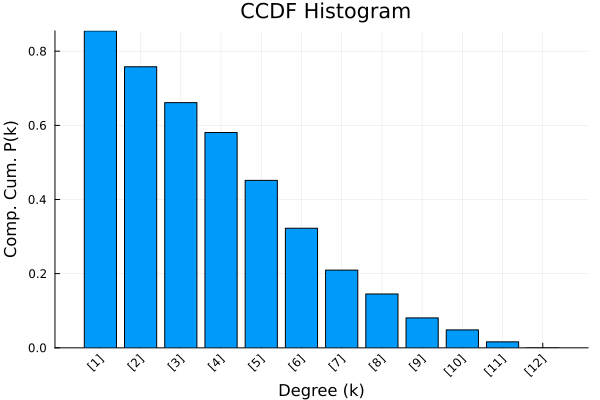

In [28]:
#degree_pdf(graph, bins, log_scale, CCDF)
degree_pdf2(network,12,false,true)

In [ ]:
bin_counts = zeros(Int, length(bin_edges))
delta=bin_edges[2]-bin_edges[1]+1e-12

for element in log_data
    # Find the index of the bin the element belongs to
    bin_index = findfirst(x -> x >= element, bin_edges[2:length(bin_counts)])
    # Increment the count for the corresponding bin
    bin_counts[bin_index] += 1
  end

bin_counts=bin_counts[1:length(bin_counts)-1]

probabilities=bin_counts/total_elements

bar(
    xlabel="log(k)",
    ylabel="Probability",
    title="Log-Log Scale Histogram",
    xticks=bin_edges,
    legend=false,
    bar_width=0.8,
    bar_edges=false,
    seriestype=:bar,
    bins=bin_edges,
    weights=probabilities,
)


In [ ]:
bin_counts = zeros(Int, length(bin_edges))
delta=bin_edges[2]-bin_edges[1]+1e-12

for element in log_data
    # Find the index of the bin the element belongs to
    bin_index = findfirst(x -> x >= element, bin_edges[2:length(bin_counts)])
    # Increment the count for the corresponding bin
    bin_counts[bin_index] += 1
  end

bin_counts=bin_counts[1:length(bin_counts)-1]

probabilities=bin_counts/total_elements


10-element Vector{Float64}:
 0.20398009950248755
 0.4096185737976783
 0.13349917081260365
 0.08872305140961857
 0.05555555555555555
 0.050304035378662244
 0.026533996683250415
 0.017965726920950803
 0.011332227750138198
 0.0024875621890547263

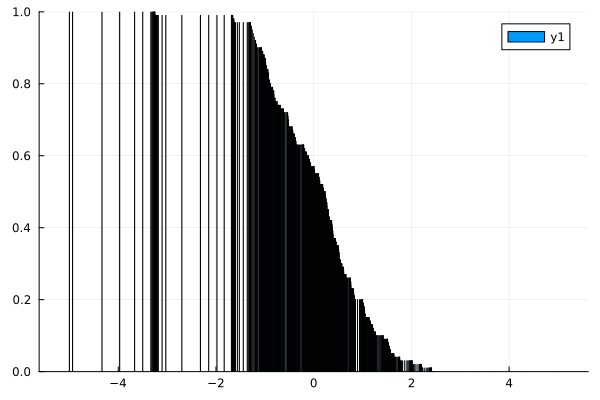

In [137]:
using Plots, StatsBase
g1 = randn(100)
gcdf = ecdf(g1)
plot(x ->1- gcdf(x),  seriestype=:bar, num_bins=10)

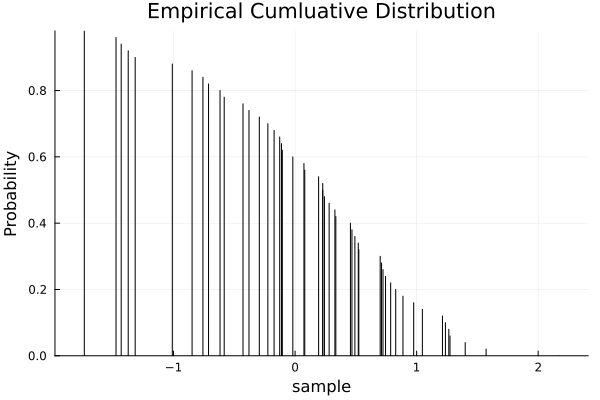

In [134]:
using Plots
n = 50
g1 = [randn() for i = 1:n] # generate the samples

p = plot(sort(g1), 1 .- (1:n)./n,
    xlabel = "sample", ylabel = "Probability",
    title = "Empirical Cumluative Distribution", label = "", seriestype=:bar, num_bins=10 )

In [118]:
using StatsBase
using HistogramTools

x = randn(10^2)
hist_obj = fit(Histogram, x, nbins=10)

# Extract bin edges
bin_edges = edges(hist_obj)


#plt=bar(x, y, label="Original Data", xlabel="X", ylabel="Y")

# Plot the modified data



LoadError: ArgumentError: Package HistogramTools not found in current path.
- Run `import Pkg; Pkg.add("HistogramTools")` to install the HistogramTools package.

In [117]:
Pkg.add("HistogramTools")

LoadError: The following package names could not be resolved:
 * HistogramTools (not found in project, manifest or registry)
[36m   Suggestions:[39m [0m[1mH[22m[0m[1mi[22m[0m[1ms[22m[0m[1mt[22m[0m[1mo[22m[0m[1mg[22m[0m[1mr[22m[0m[1ma[22m[0m[1mm[22m[0m[1mT[22mhresh[0m[1mo[22mlding

In [ ]:
plt=plot(x, y, label="Original Data", xlabel="X", ylabel="Y")

# Plot the modified data

collect(plt[1][1][:y])

11-element Vector{Float64}:
 2.0
 2.2
 2.4
 2.6
 2.8
 3.0
 3.2
 3.4
 3.6
 3.8
 4.0

# Need Help?

* Learning: https://julialang.org/learning/
* Documentation: https://docs.julialang.org/
* Questions & Discussions:
  * https://discourse.julialang.org/
  * http://julialang.slack.com/
  * https://stackoverflow.com/questions/tagged/julia

If you ever ask for help or file an issue about Julia, you should generally provide the output of `versioninfo()`.

Add new code cells by clicking the `+ Code` button (or _Insert_ > _Code cell_).

Have fun!

<img src="https://raw.githubusercontent.com/JuliaLang/julia-logo-graphics/master/images/julia-logo-mask.png" height="100" />